
__Building a CNN to classify images with the CIFAR-10 Dataset__

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

* __Airplane__
* __Automobile__
* __Bird__
* __Cat__
* __Deer__
* __Dog__
* __Frog__
* __Horse__
* __Ship__
* __Truck__

Each class contains an equal distribution, boasting 6,000 images. From the total image count, 50,000 are designated for training while the remaining 10,000 are set aside for testing.

### __Building Convolutional Neural Nets__

In this project we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

### __Objectives__

* __Data Insights and Exploration__
   - Familiarize with the CIFAR-10 dataset.
   - Visually inspect sample images from various classes to understand data distribution.

    
* __Comprehensive Data Preprocessing__
   - Normalize pixel values of the images to enhance model training efficiency.
   - Convert image labels into a one-hot encoded format suitable for classification tasks.
   - Implement data augmentation techniques to increase the dataset's variability and improve model generalization.

    
* __Architectural Design using Keras__
   - Design a Convolutional Neural Network (CNN) tailored for the CIFAR-10 dataset using the __Keras__ framework.
   - Incorporate mechanisms such as dropouts and regularizations to counteract overfitting.

    
* __Model Training Process__
   - Train the CNN using the prepared dataset.
   - Utilize callbacks to adjust the learning rate dynamically and halt the training early if no improvements are detected, restoring the best model weights from the training.

    
* __Learning Analysis__
   - Visualize the model's learning curves, observing both training and validation performance metrics over epochs.

    
* __Model Evaluation__
   - Assess the trained model's accuracy and loss on the unseen test data to determine its robustness.

    
* __Real-world Generalization Check__
   - Evaluate the model's predictive capability using an image not part of the CIFAR-10 dataset to gauge its real-world applicability.


### Load python libreries

In [2]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

In [3]:
# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


Then, let's split original training data to training and validation sets:

In [4]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples


Afterward, let's take an overview of the __CIFAR-10__ dataset:

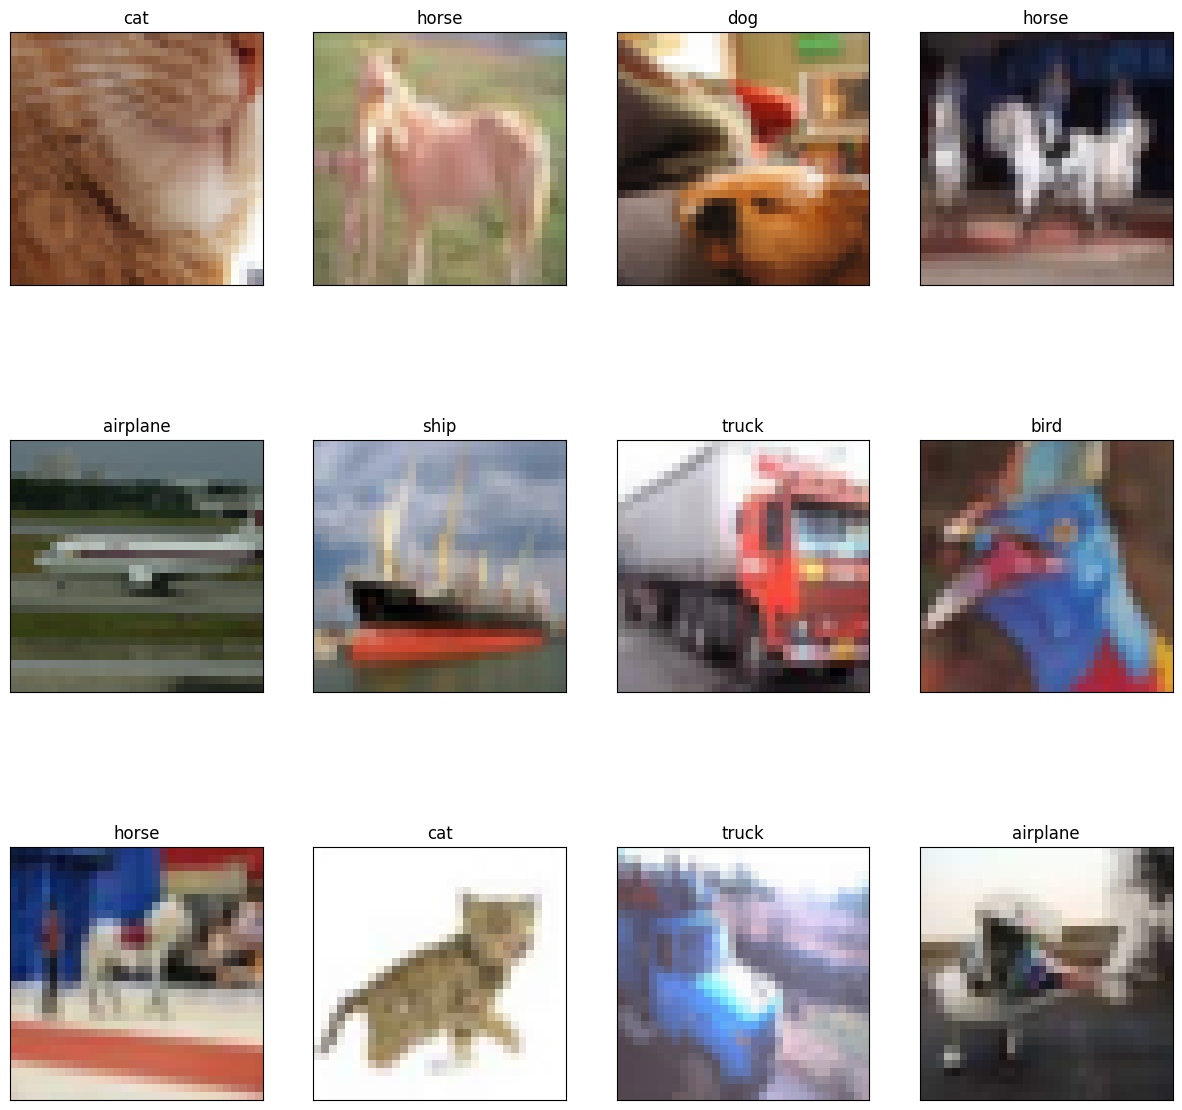

In [5]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(12):
    # Create a subplot for each image
    plt.subplot(3, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

### __Data processing__

In the **Data Preprocessing** phase, we undertake essential preparatory measures to ensure our dataset is aptly primed for the modeling process:

1. **Normalization of Image Data**

2. **One-Hot Encoding of Labels**

3. **Data Augmentation**

In [6]:
#Normalized the image data
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

In [7]:
X_test.shape

(10000, 32, 32, 3)

## One-Hot encoding label

In [8]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

## Data augmentation

Now, I am going to implement data augmentation to artificially expand the size of the training set by creating modified versions of images in the dataset. This helps improve the model's ability to generalize, thereby reducing overfitting. Data augmentation techniques such as rotations, shifts, flips, shearing, and intensity changes introduce small variations to the existing images, creating a broader set of training samples to learn from.

The choice of data augmentation techniques often depends on the specific characteristics of the dataset and the problem at hand. The __CIFAR-10__ dataset comprises small color images of objects from 10 different classes. Given the nature of these images, some augmentation techniques are more applicable than others:

* __Rotation__: A small degree of rotation can help the model become invariant to the orientation of the object. The `rotation_range=15` means the image could be rotated randomly within -15 to 15 degrees. However, large rotations could be harmful since the CIFAR-10 images are relatively small and a big rotation might put the object outside of the image.

    
* __Width and Height shift__: Small shifts can help the model become invariant to the position of the object in the image. Here, `width_shift_range=0.12` and `height_shift_range=0.12` mean the image could be moved horizontally or vertically by up to 12% of its width or height respectively. Again, since the images are small, large shifts might put the object outside of the image.

    
* __Horizontal Flip__: A horizontal flip is a sensible choice for this dataset because for many images, the object of interest remains the same when flipped horizontally (for example, a flipped car is still a car).

    
* __Zoom__: Small zooming in by up to 10% (`zoom_range=0.1`) can also help the model generalize better. However, excessive zooming might lead to significant information loss.

    
* __Brightness Range__: Changing brightness can simulate various lighting conditions. With `brightness_range=[0.9,1.1]`, the brightness of the image is randomly changed to a value between 90% and 110% of the original brightness.

    
* __Shear Intensity__: With `shear_range=10`, a shear intensity within the range of -10 to +10 degrees is applied. This transformation slants the shape of the image, helping the model to recognize objects in different perspectives.

    
* __Channel Shift Intensity__: With `channel_shift_range=0.1`, the intensities of the RGB channels are randomly shifted by up to 10% of their full scale. This can help the model handle different lighting conditions and color variations.

While some augmentation techniques like vertical flips and color jittering may not be appropriate for all classes in the __CIFAR-10__ dataset, the chosen techniques are expected to help improve the robustness and generalization capability of the model.

In [9]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

### Define CNN Model Architecture

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.


In [10]:
# Let's build a CNN using Keras' Sequential capabilities

num_classes =10

# Let's build a CNN using Keras' Sequential capabilities

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

We still have 181K parameters, even though this is a "small" model.

In [11]:
batch_size = 64

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=100,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.3337 - loss: 1.8234 - val_accuracy: 0.5209 - val_loss: 1.3263
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.5439 - loss: 1.2841 - val_accuracy: 0.6157 - val_loss: 1.0764
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.6177 - loss: 1.0756 - val_accuracy: 0.6851 - val_loss: 0.9051
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.6689 - loss: 0.9420 - val_accuracy: 0.6759 - val_loss: 0.9338
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.7060 - loss: 0.8461 - val_accuracy: 0.7293 - val_loss: 0.7820
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.7263 - loss: 0.7844 - val_accuracy: 0.7468 - val_loss: 0.7291
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7522 - loss: 0.7156 - val_accuracy: 0.7531 - val_loss: 0.7099
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - accuracy: 0.7641 - loss: 0

## Evaluate model

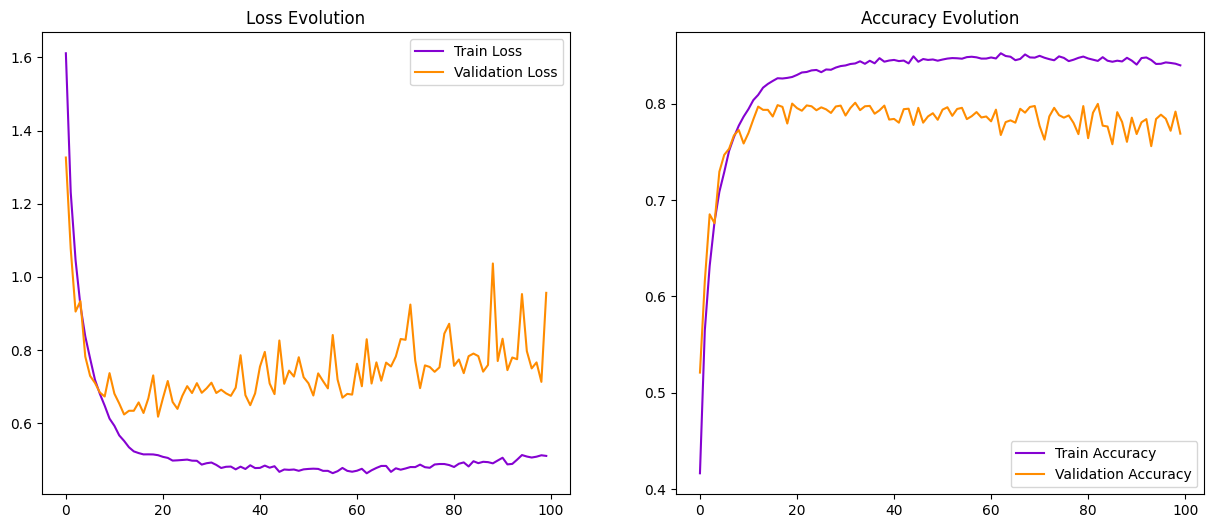

In [14]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [15]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, roc_auc_score, roc_curve 
from sklearn import metrics

y_pred_prob_nn_1 = model.predict(X_test)
y_pred_class_nn_1 = (y_pred_prob_nn_1 > 0.5).astype(int)

# Print model performance and plot the roc curve
# Convert probabilities to binary labels
y_pred_class_nn_1 = (y_pred_prob_nn_1 > 0.5).astype(int)

# Print model performance and plot the roc curve
print(f"The accuracy score of the best model is {accuracy_score(y_test, y_pred_class_nn_1)}\n")
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_1)))

print(metrics.classification_report(y_test, y_pred_class_nn_1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
The accuracy score of the best model is 0.7364

roc-auc is 0.968
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1000
           1       0.93      0.85      0.89      1000
           2       0.69      0.67      0.68      1000
           3       0.73      0.49      0.59      1000
           4       0.75      0.72      0.74      1000
           5       0.89      0.49      0.63      1000
           6       0.72      0.93      0.81      1000
           7       0.91      0.69      0.78      1000
           8       0.84      0.85      0.85      1000
           9       0.86      0.88      0.87      1000

   micro avg       0.80      0.74      0.77     10000
   macro avg       0.81      0.74      0.76     10000
weighted avg       0.81      0.74      0.76     10000
 samples avg       0.74      0.74      0.74     10000



## Performance and prediction 

In [16]:
import cv2
import urllib.request

# Fetch the raw image from GitHub
img = cv2.imread('horse.jpg') 
cv2.imshow('image', img) 
 
# Maintain output window until
# user presses a key
cv2.waitKey(0)        
 
# Destroying present windows on screen
cv2.destroyAllWindows() 

Visualize the images

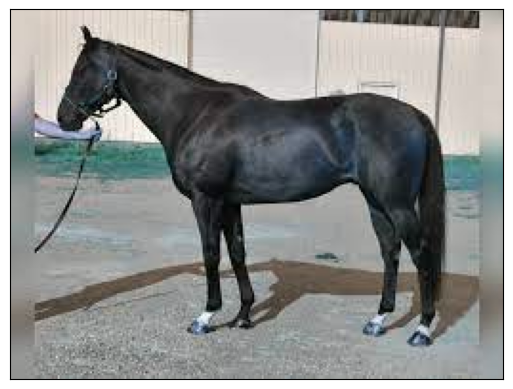

In [17]:
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.grid()
plt.show()

Make prediction

In [19]:
# Resize it to 32x32 pixels
image = cv2.resize(img, (32,32))

# Normalize the image
image = (image-mean)/(std+1e-7)

# Add an extra dimension because the model expects a batch of images
image = image.reshape((1, 32, 32, 3))

In [20]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [21]:
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  horse


As you can see the model has permormed well

## Summary and Recommendation

### Summary
In this project, we built and trained a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 50,000 training images and 10,000 test images. The classes include airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

We followed these steps:
1. **Data Loading and Preprocessing**:
    - Loaded the CIFAR-10 dataset and split it into training, validation, and test sets.
    - Normalized the pixel values of the images.
    - One-hot encoded the labels.
    - Implemented data augmentation techniques to increase the variability of the training set.

2. **Model Architecture**:
    - Designed a CNN using Keras with multiple convolutional layers, max-pooling layers, dropout layers, and dense layers.
    - The model architecture included Conv2D, MaxPooling2D, Flatten, Dense, Activation, and Dropout layers.

3. **Model Training**:
    - Compiled the model using the RMSprop optimizer and categorical cross-entropy loss function.
    - Trained the model on the training set and validated it on the validation set.

4. **Model Evaluation**:
    - Evaluated the model's performance on the test set.
    - Visualized the training and validation loss and accuracy over epochs.
    - Calculated the accuracy score, ROC-AUC score, and generated a classification report.

5. **Prediction**:
    - Made predictions on a new image and displayed the predicted class.

### Recommendation
Based on the results, the model performed well on the CIFAR-10 dataset. Here are some recommendations for further improvement:

1. **Hyperparameter Tuning**:
    - Experiment with different hyperparameters such as learning rate, batch size, and number of epochs to find the optimal settings.
    - Use techniques like grid search or random search for hyperparameter optimization.

2. **Model Architecture**:
    - Try deeper and more complex architectures such as ResNet, VGG, or Inception to improve accuracy.
    - Experiment with different activation functions and regularization techniques.

3. **Data Augmentation**:
    - Explore additional data augmentation techniques such as vertical flips, color jittering, and random cropping.
    - Use more aggressive augmentation to further increase the variability of the training set.

4. **Transfer Learning**:
    - Utilize pre-trained models on larger datasets (e.g., ImageNet) and fine-tune them on the CIFAR-10 dataset.
    - This can help improve performance, especially if the dataset is small.

5. **Ensemble Methods**:
    - Combine predictions from multiple models to create an ensemble, which can improve overall accuracy and robustness.

6. **Evaluation Metrics**:
    - Use additional evaluation metrics such as precision, recall, and F1-score to get a more comprehensive understanding of the model's performance.
    - Perform cross-validation to ensure the model's generalization capability.

